In [9]:
import json
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict # Import defaultdict
import numpy as np # Often useful with pandas/plotting
import re # For generalizing reasons

# Define the base directory where benchmark results are stored
BASE_DIR = "logs/benchmark"

# List to store data extracted from LLM turns across all games and configurations
all_llm_turns_data = []
total_llm_turns = 0
total_llm_invalid_moves = 0
all_llm_reasons = Counter() # Using Counter to easily aggregate reasons
config_game_stats = defaultdict(lambda: {"total_games": 0, "llm_wins": 0, "draws": 0, "opponent_wins": 0}) # Store win/loss/draw stats per config

# Check if base directory exists
if not os.path.isdir(BASE_DIR):
    print(f"Error: Base directory '{BASE_DIR}' not found.")
    # You might want to raise an exception or handle this differently
    # For a notebook, printing an error might be sufficient initially.
else:
    # Iterate through benchmark configurations (subdirectories within BASE_DIR)
    for config_folder in os.listdir(BASE_DIR):
        config_path = os.path.join(BASE_DIR, config_folder)

        # Process only if it's a directory
        if os.path.isdir(config_path):
            print(f"Processing folder: {config_folder}")

            # Determine LLM color based on folder name convention (e.g., 'w_llm_vs_...' or 'b_llm_vs_...')
            llm_color = None
            opponent_color = None
            if 'w_llm' in config_folder.lower():
                llm_color = "White"
                opponent_color = "Black"
            elif 'b_llm' in config_folder.lower():
                llm_color = "Black"
                opponent_color = "White"
            else:
                print(f"  Warning: Could not determine LLM color for config '{config_folder}'. Win stats might be inaccurate.")


            # Iterate through game files (JSON) in the folder
            # Sort files to process game_1 first for the attempts plot
            sorted_files = sorted([f for f in os.listdir(config_path) if f.startswith("game_") and f.endswith(".json")])

            for filename in sorted_files:
                file_path = os.path.join(config_path, filename)

                try:
                    with open(file_path, 'r') as f:
                        game_data = json.load(f)

                    # --- Game Outcome Analysis ---
                    config_game_stats[config_folder]["total_games"] += 1
                    winner = game_data.get("winner")
                    if winner and llm_color: # Only count if we know the LLM's color
                        if winner == llm_color:
                            config_game_stats[config_folder]["llm_wins"] += 1
                        elif winner == opponent_color:
                             config_game_stats[config_folder]["opponent_wins"] += 1
                        elif winner.lower() == "draw":
                             config_game_stats[config_folder]["draws"] += 1
                        # else: winner might be something unexpected, ignore for now
                    elif winner and winner.lower() == "draw": # Count draws even if LLM color unknown
                        config_game_stats[config_folder]["draws"] += 1
                    # --- End Game Outcome Analysis ---


                    # Process the list of turns in the game data
                    for turn_index, turn_info in enumerate(game_data.get("turns", [])):
                        move_desc = turn_info.get("move", "")

                        # Identify turns made by the LLM.
                        # Note: This assumes the LLM might be playing either White or Black depending on the config.
                        # The reason string itself contains the player color ("White attempted...", "Black attempted...")
                        # Check if the move description indicates an LLM move OR a forced move (which implies LLM failed attempts)
                        is_llm_turn = False
                        if llm_color == "White" and ("LLM moved" in move_desc or "Forced valid move:" in move_desc or "White attempted" in str(turn_info.get("reasons", {}))):
                             is_llm_turn = True
                        elif llm_color == "Black" and ("LLM moved" in move_desc or "Forced valid move:" in move_desc or "Black attempted" in str(turn_info.get("reasons", {}))):
                             is_llm_turn = True
                        # Add a check for forced moves specifically if LLM color is unknown but we still want turn stats
                        elif llm_color is None and ("LLM moved" in move_desc or "Forced valid move:" in move_desc):
                             is_llm_turn = True # Less precise, but captures explicit LLM moves


                        if is_llm_turn:
                            total_llm_turns += 1
                            invalid_moves_in_turn = turn_info.get("invalid_moves", 0)
                            reasons_in_turn = turn_info.get("reasons", {})

                            # Accumulate total invalid moves by LLM
                            total_llm_invalid_moves += invalid_moves_in_turn

                            # --- Generalize and Accumulate Reasons ---
                            generalized_reasons_in_turn = Counter()
                            for reason, count in reasons_in_turn.items():
                                # Check if the reason matches the pattern "Player attempted invalid move from (x,y) to (z,w)"
                                match = re.match(r"^(White|Black) attempted invalid move from \(\d+,\d+\) to \(\d+,\d+\)$", reason)
                                if match:
                                    player = match.group(1) # Extract 'White' or 'Black'
                                    # Only count if the player matches the determined LLM color, or if color is unknown
                                    if llm_color is None or player == llm_color:
                                        generalized_key = f"{player} general invalid move"
                                        generalized_reasons_in_turn[generalized_key] += count
                                    # else: it was an opponent's invalid move during LLM's turn (less likely with current benchmark structure but possible)
                                elif llm_color is None or (llm_color == "White" and reason.startswith("White")) or (llm_color == "Black" and reason.startswith("Black")):
                                     # Keep other reasons if they pertain to the LLM or if color is unknown
                                     generalized_reasons_in_turn[reason] += count
                            all_llm_reasons.update(generalized_reasons_in_turn)
                            # --- End Generalization ---


                            # Store detailed data for potential further analysis or plotting
                            all_llm_turns_data.append({
                                "config": config_folder,
                                "game": filename,
                                "turn_index": turn_index, # Overall turn index in the game
                                "move_desc": move_desc,
                                "invalid_moves": invalid_moves_in_turn,
                                # Store the original reasons dict if needed, but aggregation uses generalized ones
                                "reasons_original": reasons_in_turn
                            })

                except json.JSONDecodeError:
                    print(f"  Warning: Error decoding JSON from file: {file_path}")
                except Exception as e:
                    print(f"  Warning: Error processing file {file_path}: {e}")

            # Print summary for the config folder after processing all its games
            stats = config_game_stats[config_folder]
            print(f"  Summary for {config_folder}: Total Games={stats['total_games']}, LLM Wins={stats['llm_wins']}, Opponent Wins={stats['opponent_wins']}, Draws={stats['draws']}")


Processing folder: w_llm_vs_b_random_few_shot
  Summary for w_llm_vs_b_random_few_shot: Total Games=12, LLM Wins=0, Opponent Wins=0, Draws=9
Processing folder: w_llm_vs_b_random_vanilla
  Summary for w_llm_vs_b_random_vanilla: Total Games=12, LLM Wins=0, Opponent Wins=0, Draws=12
Processing folder: w_random_vs_b_llm_few_shot
  Summary for w_random_vs_b_llm_few_shot: Total Games=12, LLM Wins=0, Opponent Wins=0, Draws=12
Processing folder: w_random_vs_b_llm_vanilla
  Summary for w_random_vs_b_llm_vanilla: Total Games=12, LLM Wins=0, Opponent Wins=0, Draws=12



--- LLM Performance Summary ---
Total LLM Turns Analyzed: 480
Total LLM Invalid Moves Made (sum across turns): 730
Average Invalid Moves per LLM Turn: 1.5208

--- Analysis of LLM Invalid Move Reasons (Generalized) ---
Frequency of Each Generalized Invalid Move Reason:
                                 Reason  Count
0            White general invalid move    367
1            Black general invalid move    178
2  Black tried to move opponent's piece     79
3    Black tried to move an empty space     68
4  White tried to move opponent's piece     21
5    White tried to move an empty space     17


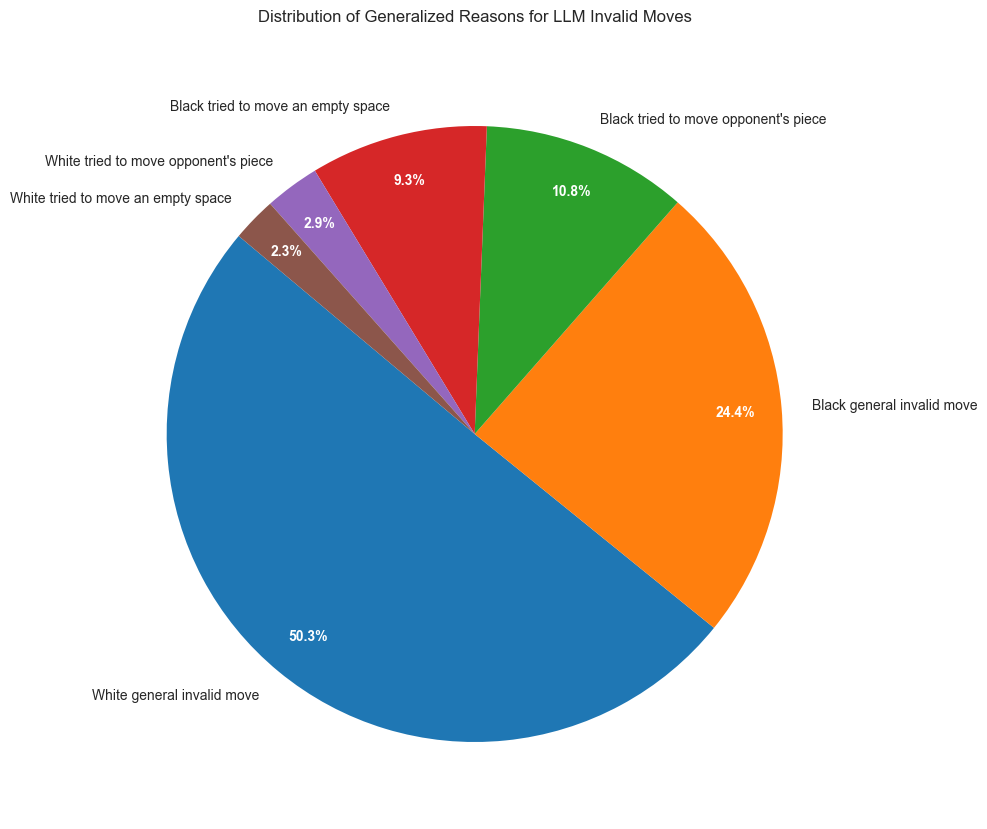

In [17]:

# --- Analysis and Visualization ---

# Create a Pandas DataFrame from the collected LLM turn data
if all_llm_turns_data:
    df_llm_turns = pd.DataFrame(all_llm_turns_data)

    # 1. Calculate the overall ratio of invalid moves to total LLM turns
    if total_llm_turns > 0:
        invalid_ratio = total_llm_invalid_moves / total_llm_turns
        print("\n--- LLM Performance Summary ---")
        print(f"Total LLM Turns Analyzed: {total_llm_turns}")
        print(f"Total LLM Invalid Moves Made (sum across turns): {total_llm_invalid_moves}")
        print(f"Average Invalid Moves per LLM Turn: {invalid_ratio:.4f}")
    else:
        print("No LLM turns were found in the logs.")

    # 2. Plot Pie Chart of Generalized Invalid Move Reasons
    if total_llm_invalid_moves > 0:
        print("\n--- Analysis of LLM Invalid Move Reasons (Generalized) ---")

        # Convert the aggregated Counter to a DataFrame for easier handling and plotting
        df_reasons = pd.DataFrame(all_llm_reasons.items(), columns=['Reason', 'Count'])
        df_reasons = df_reasons.sort_values(by='Count', ascending=False).reset_index(drop=True)

        print("Frequency of Each Generalized Invalid Move Reason:")
        with pd.option_context('display.max_rows', None, 'display.max_colwidth', None): # Show all rows/full text
             print(df_reasons)

        # Plot the pie chart
        plt.figure(figsize=(10, 10))
        # Use autopct to show percentages, threshold small slices if needed
        # '%1.1f%%' means floating point number with 1 decimal place followed by '%'
        # lambda p: '{:.1f}%'.format(p) if p > 1 else '' # Example to hide small labels
        wedges, texts, autotexts = plt.pie(df_reasons['Count'], labels=df_reasons['Reason'], autopct='%1.1f%%',
                                           startangle=140, pctdistance=0.85)
        plt.title('Distribution of Generalized Reasons for LLM Invalid Moves', pad=20)
        # Improve text visibility if needed
        for autotext in autotexts:
            autotext.set_color('white')
            autotext.set_weight('bold')
        plt.show()

    else:
        print("\nNo invalid moves were recorded for the LLM.")



--- Average Invalid Attempts per LLM Turn (All Games per Config - Combined) ---


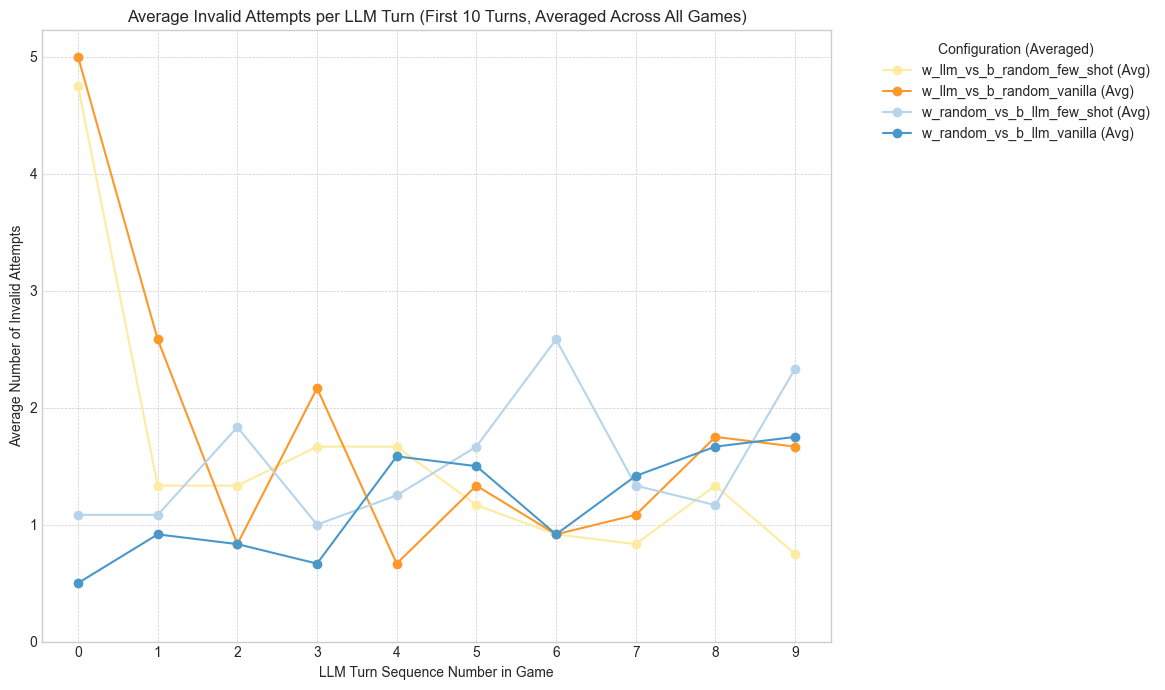

In [18]:

# 3. Plot Average Invalid Attempts per LLM Turn across all games for each configuration
if not df_llm_turns.empty:
    print("\n--- Average Invalid Attempts per LLM Turn (All Games per Config - Combined) ---")
    plt.style.use('seaborn-v0_8-whitegrid') # Use a nice style
    plt.figure(figsize=(14, 7)) # Create one figure for all plots
    ax = plt.gca() # Get current axes

    configs = sorted(df_llm_turns['config'].unique()) # Sort configs for consistent color assignment
    max_invalid_moves_overall = 0 # Track max avg invalid moves for y-axis limit
    max_turns_plotted = 0 # Track max turns plotted for x-axis limit
    N_TURNS_TO_PLOT = 20 # Define how many initial turns to plot the average for

    # Prepare color mapping
    white_configs = [c for c in configs if c.startswith('w_llm')]
    black_configs = [c for c in configs if '_b_llm' in c]
    other_configs = [c for c in configs if c not in white_configs and c not in black_configs]

    num_white_configs = len(white_configs)
    num_black_configs = len(black_configs)
    num_other_configs = len(other_configs)

    # Use perceptually uniform colormaps if possible, adjust range for visibility
    # Updated to use plt.get_cmap to avoid DeprecationWarning
    white_cmap = plt.get_cmap('YlOrBr') # Yellow-Orange-Brown for light
    black_cmap = plt.get_cmap('Blues') # Blues for dark
    other_cmap = plt.get_cmap('Greens') # Greens for others

    white_idx = 0
    black_idx = 0
    other_idx = 0

    for config_name in configs:
        config_data = df_llm_turns[df_llm_turns['config'] == config_name].copy()
        if config_data.empty:
            print(f"No data found for config '{config_name}'. Skipping.")
            continue

        # Add LLM turn sequence number within each game
        # Ensure sorting for correct cumcount
        config_data = config_data.sort_values(by=['game', 'turn_index'])
        config_data['llm_turn_seq'] = config_data.groupby('game').cumcount()

        # Calculate average invalid moves per LLM turn sequence number across all games for this config
        avg_invalid_per_turn = config_data.groupby('llm_turn_seq')['invalid_moves'].mean()

        # Limit to first N turns
        avg_invalid_plot = avg_invalid_per_turn.head(N_TURNS_TO_PLOT)

        if not avg_invalid_plot.empty:
            # Determine color based on config name and role
            plot_color = None
            is_white_llm = config_name in white_configs
            is_black_llm = config_name in black_configs

            if is_white_llm:
                # Generate light colors (avoiding too light/dark ends of map)
                color_val = 0.2 + 0.6 * (white_idx / num_white_configs) if num_white_configs > 1 else 0.5
                plot_color = white_cmap(color_val)
                white_idx += 1
            elif is_black_llm:
                # Generate dark colors (avoiding too light/dark ends of map)
                color_val = 0.3 + 0.6 * (black_idx / num_black_configs) if num_black_configs > 1 else 0.6
                plot_color = black_cmap(color_val)
                black_idx += 1
            else:
                # Assign color for configs where LLM role isn't clear or is different
                color_val = 0.3 + 0.6 * (other_idx / num_other_configs) if num_other_configs > 1 else 0.6
                plot_color = other_cmap(color_val)
                other_idx += 1


            # Plot average invalid moves against the sequence of LLM turns
            turn_sequence = avg_invalid_plot.index
            ax.plot(turn_sequence, avg_invalid_plot.values, marker='o', linestyle='-', label=f"{config_name} (Avg)", color=plot_color)

            # Update overall max values for axis limits
            current_max_invalid = avg_invalid_plot.values.max()
            if current_max_invalid > max_invalid_moves_overall:
                max_invalid_moves_overall = current_max_invalid
            # Track the maximum turn index plotted (can be less than N_TURNS_TO_PLOT if data is shorter)
            if not turn_sequence.empty:
                current_max_turn = turn_sequence.max() + 1 # +1 because index starts at 0
                if current_max_turn > max_turns_plotted:
                    max_turns_plotted = current_max_turn

        else:
                print(f"No averaged LLM turn data to plot for config '{config_name}' within the first {N_TURNS_TO_PLOT} turns.")

    # Finalize the combined plot after the loop
    if max_turns_plotted > 0: # Only finalize if something was plotted
        # Adjust max_turns_plotted if it exceeds N_TURNS_TO_PLOT (shouldn't happen with .head(), but safe)
        max_turns_plotted = min(max_turns_plotted, N_TURNS_TO_PLOT)

        ax.set_title(f'Average Invalid Attempts per LLM Turn (First {max_turns_plotted} Turns, Averaged Across All Games)')
        ax.set_xlabel('LLM Turn Sequence Number in Game')
        ax.set_ylabel('Average Number of Invalid Attempts')
        # Set x-ticks based on the maximum number of turns plotted
        ax.set_xticks(range(max_turns_plotted))
        # Set y-ticks based on the overall maximum average invalid moves + buffer
        # Use ceil for the upper limit, ensure at least ticks 0, 1
        upper_y_limit = max(1, np.ceil(max_invalid_moves_overall)) + 1
        ax.set_yticks(np.arange(upper_y_limit))
        ax.grid(True, which='both', linestyle='--', linewidth=0.5)
        ax.legend(title="Configuration (Averaged)", bbox_to_anchor=(1.05, 1), loc='upper left') # Add legend outside plot
        plt.tight_layout(rect=[0, 0, 0.85, 1]) # Adjust layout to make space for legend
        plt.show()
    else:
        print("No data was plotted.")

In [23]:
df_llm_turns

,config,game,turn_index,move_desc,invalid_moves,reasons_original
0,w_llm_vs_b_random_few_shot,game_1.json,0,"LLM moved from (4,6) to (5,6)",4,"{'White attempted invalid move from (4,3) to (..."
1,w_llm_vs_b_random_few_shot,game_1.json,2,"LLM moved from (5,6) to (6,6)",1,"{'White attempted invalid move from (4,4) to (..."
2,w_llm_vs_b_random_few_shot,game_1.json,4,"LLM moved from (6,6) to (6,7)",1,"{'White attempted invalid move from (4,4) to (..."
3,w_llm_vs_b_random_few_shot,game_1.json,6,"Forced valid move: from (2,4) to (2,5)",5,"{'White attempted invalid move from (4,4) to (..."
4,w_llm_vs_b_random_few_shot,game_1.json,8,"LLM moved from (3,4) to (2,4)",1,"{'White attempted invalid move from (4,4) to (..."
...,...,...,...,...,...,...
475,w_random_vs_b_llm_vanilla,game_9.json,11,"LLM moved from (0,3) to (0,2)",1,{'Black tried to move an empty space': 1}
476,w_random_vs_b_llm_vanilla,game_9.json,13,"LLM moved from (4,1) to (4,2)",2,"{'Black tried to move opponent's piece': 1, 'B..."
477,w_random_vs_b_llm_vanilla,game_9.json,15,"LLM moved from (6,4) to (5,4)",1,{'Black tried to move an empty space': 1}
478,w_random_vs_b_llm_vanilla,game_9.json,17,"LLM moved from (0,4) to (0,3)",2,"{'Black attempted invalid move from (5,4) to (..."



--- Generating combined plot: LLM Invalid Move Comparison: Vanilla vs Few-Shot ---
Comparing categories:
- Vanilla: w_llm_vs_b_random_vanilla, w_random_vs_b_llm_vanilla
- Few-Shot: w_llm_vs_b_random_few_shot, w_random_vs_b_llm_few_shot
Plotting up to the first 20 LLM turns.


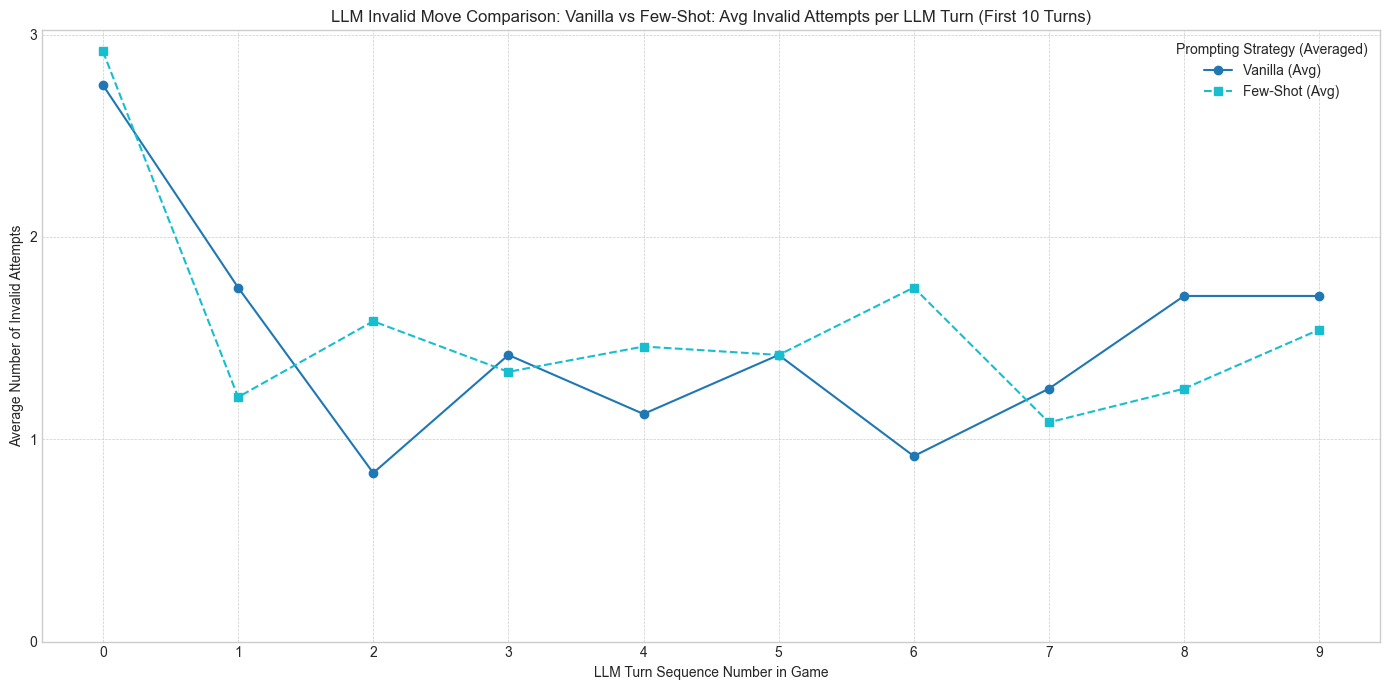

In [25]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd # Assuming df_llm_turns is a pandas DataFrame

# Assume df_llm_turns and N_TURNS_TO_PLOT are defined in previous cells

def plot_combined_comparison(df_llm_turns, configs_map, plot_title, n_turns_to_plot):
    """
    Generates a single comparison plot for average invalid moves, combining data
    based on categories (e.g., "Vanilla", "Few-Shot") regardless of player color.

    Args:
        df_llm_turns (pd.DataFrame): DataFrame containing LLM turn data.
                                     Must include 'config', 'turn_index', 'invalid_moves'.
        configs_map (dict): Dictionary mapping labels (e.g., "Vanilla") to
                            a list of config names belonging to that category.
        plot_title (str): The title for the plot.
        n_turns_to_plot (int): The maximum number of LLM turns to include in the plot.
    """
    fig_compare, ax_compare = plt.subplots(figsize=(14, 7))
    max_invalid_moves_compare = 0
    max_turns_plotted_compare = 0
    plotted_something = False

    print(f"\n--- Generating combined plot: {plot_title} ---")
    print(f"Comparing categories:")
    for label, names in configs_map.items():
        print(f"- {label}: {', '.join(names)}")
    print(f"Plotting up to the first {n_turns_to_plot} LLM turns.")

    # Define distinct colors/styles
    # Using tab10 colormap for potentially more distinct colors if needed later
    colors = plt.cm.tab10(np.linspace(0, 1, len(configs_map)))
    linestyles = ['-', '--', ':', '-.']
    markers = ['o', 's', '^', 'd']
    plot_idx = 0 # Index for cycling through styles

    for label, config_names_list in configs_map.items():
        # Filter df_llm_turns for all configs belonging to the current label
        category_df = df_llm_turns[df_llm_turns['config'].isin(config_names_list)].copy() # Use .copy()

        if not category_df.empty:
            # Calculate LLM turn sequence number for each row in the filtered data
            # This needs to be done *after* filtering by category but *before* aggregation
            def get_llm_turn_seq(row):
                config = row['config']
                turn_index = row['turn_index']
                # Determine player color based on config name convention
                if config.startswith('w_llm'): # White LLM plays on even game turns (0, 2, 4, ...)
                    return turn_index // 2
                elif config.startswith('b_llm') or 'vs_b_llm' in config: # Black LLM plays on odd game turns (1, 3, 5, ...)
                    return (turn_index - 1) // 2
                else:
                    # Handle unexpected config names if necessary, or assume they fit the pattern
                    print(f"Warning: Could not determine LLM player role for config '{config}' in category '{label}'. Assuming White if turn index is even, Black if odd.")
                    # Fallback logic (might be incorrect if turn_index doesn't strictly alternate)
                    return turn_index // 2 if turn_index % 2 == 0 else (turn_index - 1) // 2


            category_df['llm_turn_seq'] = category_df.apply(get_llm_turn_seq, axis=1)

            # Filter for the first N_TURNS_TO_PLOT LLM turns based on the calculated sequence number
            category_df_filtered = category_df[category_df['llm_turn_seq'] < n_turns_to_plot]

            if not category_df_filtered.empty:
                # Calculate average invalid moves per LLM turn sequence number across all games for this category
                avg_invalid_plot = category_df_filtered.groupby('llm_turn_seq')['invalid_moves'].mean()

                if not avg_invalid_plot.empty:
                    plotted_something = True
                    turn_sequence = avg_invalid_plot.index # Index is the llm_turn_seq
                    ax_compare.plot(turn_sequence, avg_invalid_plot.values,
                                    marker=markers[plot_idx % len(markers)],
                                    linestyle=linestyles[plot_idx % len(linestyles)],
                                    color=colors[plot_idx % len(colors)],
                                    label=f"{label} (Avg)")

                    # Update overall max values for axis limits for this specific plot
                    current_max_invalid = avg_invalid_plot.values.max()
                    if current_max_invalid > max_invalid_moves_compare:
                        max_invalid_moves_compare = current_max_invalid

                    # Track the maximum turn index plotted (using llm_turn_seq)
                    if not turn_sequence.empty:
                        current_max_turn = turn_sequence.max() + 1 # +1 because index starts at 0
                        if current_max_turn > max_turns_plotted_compare:
                            max_turns_plotted_compare = current_max_turn
                    plot_idx += 1
                else:
                     print(f"No averaged LLM turn data to plot for category '{label}' after grouping (within first {n_turns_to_plot} turns).")
            else:
                print(f"No LLM turns found for category '{label}' within the first {n_turns_to_plot} LLM turns.")
        else:
            print(f"No data found for any configs in category '{label}': {', '.join(config_names_list)}")


    # Finalize the combined comparison plot
    if plotted_something and max_turns_plotted_compare > 0:
        # Adjust max_turns_plotted if it exceeds N_TURNS_TO_PLOT
        max_turns_plotted_compare = min(max_turns_plotted_compare, n_turns_to_plot)

        ax_compare.set_title(f'{plot_title}: Avg Invalid Attempts per LLM Turn (First {max_turns_plotted_compare} Turns)')
        ax_compare.set_xlabel('LLM Turn Sequence Number in Game')
        ax_compare.set_ylabel('Average Number of Invalid Attempts')
        # Set x-ticks based on the maximum number of turns plotted
        ax_compare.set_xticks(range(max_turns_plotted_compare))
        # Set y-ticks based on the overall maximum average invalid moves + buffer
        upper_y_limit = max(1, np.ceil(max_invalid_moves_compare)) + 1
        ax_compare.set_yticks(np.arange(upper_y_limit))
        ax_compare.grid(True, which='both', linestyle='--', linewidth=0.5)
        ax_compare.legend(title="Prompting Strategy (Averaged)")
        plt.tight_layout()
        plt.show()
    elif plotted_something:
         print(f"Data was found for {plot_title}, but the calculated maximum turns to plot is zero. Check data or logic.")
    else:
        print(f"No data was plotted for the comparison: {plot_title}.")


# --- Generate Combined Comparison Plot ---

# Define the categories and their corresponding config names
comparison_configs = {
    "Vanilla": [
        'w_llm_vs_b_random_vanilla',
        'w_random_vs_b_llm_vanilla'
    ],
    "Few-Shot": [
        'w_llm_vs_b_random_few_shot',
        'w_random_vs_b_llm_few_shot'
    ]
}

# Generate the single plot comparing Vanilla vs Few-Shot across all relevant games
plot_combined_comparison(
    df_llm_turns,
    comparison_configs,
    "LLM Invalid Move Comparison: Vanilla vs Few-Shot",
    N_TURNS_TO_PLOT
)

# %% cell 5 code


In [26]:
import numpy as np
from collections import Counter
import pandas as pd # Assuming pandas is used and df_llm_turns is a DataFrame

print("--- Benchmark Statistics ---")

# Ensure df_llm_turns exists and is not empty
if 'df_llm_turns' in locals() and not df_llm_turns.empty:

    # 1. Overall Invalid Move Statistics
    total_llm_turns = len(df_llm_turns)
    total_invalid_moves = df_llm_turns['invalid_moves'].sum()
    overall_avg_invalid = total_invalid_moves / total_llm_turns if total_llm_turns > 0 else 0
    turns_with_invalid_moves = len(df_llm_turns[df_llm_turns['invalid_moves'] > 0])
    perc_turns_with_invalid = (turns_with_invalid_moves / total_llm_turns * 100) if total_llm_turns > 0 else 0

    print("\n--- Overall LLM Performance ---")
    print(f"Total LLM Turns Analyzed: {total_llm_turns}")
    print(f"Total Invalid Moves by LLMs: {total_invalid_moves}")
    print(f"Overall Average Invalid Moves per LLM Turn: {overall_avg_invalid:.2f}")
    print(f"Number of LLM Turns with >= 1 Invalid Move: {turns_with_invalid_moves}")
    print(f"Percentage of LLM Turns with >= 1 Invalid Move: {perc_turns_with_invalid:.2f}%")

    # 2. Per-Configuration Statistics
    print("\n--- Performance by Configuration ---")
    config_stats = df_llm_turns.groupby('config').agg(
        total_llm_turns=('invalid_moves', 'count'),
        total_invalid_moves=('invalid_moves', 'sum'),
        avg_invalid_per_turn=('invalid_moves', 'mean'),
        median_invalid_per_turn=('invalid_moves', 'median'),
        max_invalid_in_one_turn=('invalid_moves', 'max')
    )
    # Calculate percentage of turns with invalid moves per config
    config_invalid_turns = df_llm_turns[df_llm_turns['invalid_moves'] > 0].groupby('config').size()
    config_stats['turns_with_invalid_moves'] = config_invalid_turns
    config_stats['turns_with_invalid_moves'] = config_stats['turns_with_invalid_moves'].fillna(0).astype(int)
    config_stats['perc_turns_with_invalid'] = (config_stats['turns_with_invalid_moves'] / config_stats['total_llm_turns'] * 100).fillna(0)

    # Format for better readability
    config_stats['avg_invalid_per_turn'] = config_stats['avg_invalid_per_turn'].map('{:.2f}'.format)
    config_stats['perc_turns_with_invalid'] = config_stats['perc_turns_with_invalid'].map('{:.2f}%'.format)

    print(config_stats)


    # 3. Invalid Move Reason Analysis
    print("\n--- Invalid Move Reason Analysis ---")
    all_reasons = Counter()
    total_reason_entries = 0
    turns_with_reasons = 0

    # Check if 'reasons_original' column exists
    if 'reasons_original' in df_llm_turns.columns:
        for reasons_data in df_llm_turns['reasons_original']:
            # Expecting dicts, handle potential strings or other types gracefully
            if isinstance(reasons_data, dict) and reasons_data:
                turns_with_reasons += 1
                for reason, count in reasons_data.items():
                    # Ensure count is numeric, default to 1 if not specified properly
                    reason_count = int(count) if isinstance(count, (int, float)) else 1
                    all_reasons[reason] += reason_count
                    total_reason_entries += reason_count
            # Handle cases where it might be a string representation of a dict (less ideal)
            elif isinstance(reasons_data, str):
                 try:
                     # Attempt to evaluate if it looks like a dict
                     import ast
                     parsed_dict = ast.literal_eval(reasons_data)
                     if isinstance(parsed_dict, dict) and parsed_dict:
                         turns_with_reasons += 1
                         for reason, count in parsed_dict.items():
                             reason_count = int(count) if isinstance(count, (int, float)) else 1
                             all_reasons[reason] += reason_count
                             total_reason_entries += reason_count
                 except (ValueError, SyntaxError):
                     # If it's not a dict or valid string representation, skip
                     pass


        if all_reasons:
            print(f"Found {total_reason_entries} specific reasons across {turns_with_reasons} turns with invalid moves.")
            n_top_reasons = 15 # Show more reasons if available
            print(f"\nTop {min(n_top_reasons, len(all_reasons))} most common reasons for invalid moves:")
            for reason, count in all_reasons.most_common(n_top_reasons):
                percentage = (count / total_invalid_moves) * 100 if total_invalid_moves > 0 else 0
                print(f"- \"{reason}\": {count} times ({percentage:.2f}% of total invalid moves)")

            if len(all_reasons) > n_top_reasons:
                print(f"... and {len(all_reasons) - n_top_reasons} other distinct reasons.")
        else:
            print("No invalid move reasons could be extracted or parsed.")
            print(f"Total invalid moves recorded: {total_invalid_moves}")

    else:
        print("Column 'reasons_original' not found in the DataFrame.")

else:
    print("Variable 'df_llm_turns' not found or is empty. Cannot calculate statistics.")

print("\n--- End of Statistics ---")


--- Benchmark Statistics ---

--- Overall LLM Performance ---
Total LLM Turns Analyzed: 480
Total Invalid Moves by LLMs: 730
Overall Average Invalid Moves per LLM Turn: 1.52
Number of LLM Turns with >= 1 Invalid Move: 312
Percentage of LLM Turns with >= 1 Invalid Move: 65.00%

--- Performance by Configuration ---
                            total_llm_turns  total_invalid_moves  \
config                                                             
w_llm_vs_b_random_few_shot              120                  189   
w_llm_vs_b_random_vanilla               120                  216   
w_random_vs_b_llm_few_shot              120                  184   
w_random_vs_b_llm_vanilla               120                  141   

                           avg_invalid_per_turn  median_invalid_per_turn  \
config                                                                     
w_llm_vs_b_random_few_shot                 1.57                      1.0   
w_llm_vs_b_random_vanilla                  1.80 